In [1]:
import sys
sys.path.append('..')
import os
os.chdir('..')
import torch
import torchaudio
import os.path
from arg_extractor import extract_args_from_json
from experiment_builder import VQVAEExperimentBuilder
from model_architectures import VQVAEQuantizedInput, VQVAE
from vctk_preprocessor import read_audio
import torchaudio_transforms as transforms
import librosa.display
import matplotlib.pyplot as plt
torch.set_printoptions(profile="full")

In [2]:
args = extract_args_from_json('experiment_configs/vqvae_lr1e-2_latents4.json')
args.continue_from_epoch = 0
args.eval_out_path='audio_out'
args.eval_audio_path = 'data/vctk/raw/VCTK-Corpus/wav48/p265/p265_075.wav' 

In [3]:
# Load audio
audio_path = os.path.expanduser(args.eval_audio_path)
torchaudio.initialize_sox()
audio, sr = read_audio(audio_path, downsample=True, trim_silence=True)
torchaudio.shutdown_sox()
print(audio.shape)

mulaw = transforms.MuLawEncoding(quantization_channels=args.num_input_quantization_channels)
mulaw_expanding = transforms.MuLawExpanding(quantization_channels=args.num_input_quantization_channels)

torch.Size([1, 36925])


[-0.09838867 -0.03399658  0.10269165 ...  0.02957153  0.0262146
  0.02975464]


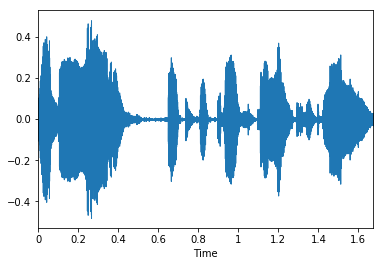

In [4]:
audio = audio.unsqueeze(0)
audio_plain = audio.numpy()[0, 0]
print(audio_plain)
plt.figure()
librosa.display.waveplot(audio_plain)

In [26]:
audio.shape

torch.Size([1, 1, 36925])

In [5]:
# Prepare model
vqvae_model = VQVAEQuantizedInput(
    input_shape=(1, 1, args.input_max_len),
    encoder_arch=args.encoder,
    vq_arch=args.vq,
    generator_arch=args.generator,
    num_speakers=109, 
    num_input_quantization_channels=args.num_input_quantization_channels)

# Select epoch
epoch = 12

# Load model from state
vqvae_experiment = VQVAEExperimentBuilder(network_model=vqvae_model,
                                    experiment_name=args.experiment_name,
                                    weight_decay_coefficient=args.weight_decay_coefficient,
                                    learning_rate=args.learning_rate,
                                    commit_coefficient=args.commit_coefficient,
                                    device=torch.device('cpu'),
                                    continue_from_epoch=epoch,
                                    train_data=None,
                                    val_data=None,
                                    test_data=None,
                                    num_epochs=None)

Building VQVAE.
Building Encoder with 4 downsampling layers.
torch.Size([1, 1, 20000])
torch.Size([1, 16, 6665])
torch.Size([1, 32, 2220])
torch.Size([1, 64, 738])
torch.Size([1, 64, 244])
torch.Size([1, 64, 244])
Building VQ layer.
Building Decoder/Generator with 5 upsampling layers.
torch.Size([1, 64, 244])
torch.Size([1, 64, 730])
torch.Size([1, 64, 2196])
torch.Size([1, 32, 6604])
torch.Size([1, 32, 19903])
torch.Size([1, 32, 20000])
torch.Size([1, 64, 20000])
torch.Size([1, 64, 20000])
torch.Size([1, 256, 20000])
/Users/simon/mlpcw/experiments/vqvae_lr1e-2_latents4 /Users/simon/mlpcw/experiments/vqvae_lr1e-2_latents4/result_outputs
Loading model train_model, at epoch 12.


In [18]:
args.eval_speaker_id = 94
# Prepare speaker tensor
speaker_id = torch.tensor(args.eval_speaker_id, dtype=torch.long)

In [19]:
vqvae_experiment.model.generator.speaker_dict.weight

Parameter containing:
tensor([[-3.7662e-01, -6.0881e-02,  2.7243e-01, -1.1907e-01, -2.6397e-01,
         -6.3684e-01,  3.8887e-01, -2.6120e-01, -1.3742e-01,  2.0686e-01,
         -1.1337e-01, -1.7474e-01,  2.7575e-01,  6.0180e-02,  3.3167e-01,
          4.8480e-01,  1.1525e-01,  1.8631e-01,  6.7635e-01, -1.1638e-01,
         -5.9849e-02, -3.2254e-01,  4.1190e-01,  1.5491e-01, -4.8341e-01,
         -2.0554e-01,  1.3615e-02, -1.0145e+00,  1.0343e-01, -3.0435e-01,
          2.3168e-01,  2.2372e-01,  3.4156e-01,  2.1569e-01,  3.8965e-01,
         -5.2155e-01,  3.0392e-01,  1.4646e-01,  1.0920e-02,  5.8180e-01,
         -4.2437e-03, -2.4511e-01, -2.0152e-01, -4.0366e-01, -1.2333e-02,
          4.1283e-01,  1.8208e-01, -4.3795e-01,  7.6619e-02,  3.0519e-01,
          4.1476e-02, -3.1901e-02, -2.0958e-01,  4.0985e-01,  4.9664e-03,
         -1.1942e-01, -8.5071e-02,  4.1870e-01,  6.9901e-03,  4.1580e-01,
         -2.1092e-01,  3.4315e-01,  5.8783e-02, -8.2462e-01],
        [-2.9391e-01,  9.597

In [20]:
out_mulaw = vqvae_experiment.convert(x=mulaw(audio), y=speaker_id)

out = mulaw_expanding(out_mulaw).detach()
print(out_mulaw)
print(out.shape)

tensor([[128, 128, 128, 128, 128, 128, 187, 187, 187, 187, 187, 187, 187, 187,
          72,  72,  72,  72,  72,  72,  72,  72,  72,  72,  72,  72,  72,  72,
          72,  72,  72,  72,  72,  72,  72,  72,  72,  72,  72,  72,  72,  72,
          72,  72,  72,  72,  72,  72,  72,  72,  72,  72,  72,  72,  72,  72,
          72,  72,  72,  72,  72,  72,  72,  72,  72,  72,  72,  72,  72,  72,
          72,  72,  72,  72,  72,  72,  72,  72,  72,  72,  72,  72,  75,  75,
          75,  75,  77,  77,  77,  77,  79,  77,  77,  75,  75,  75,  75,  75,
          75,  75,  75,  75,  75,  75,  75,  75,  75,  75,  75,  75,  75,  75,
          75,  75,  75,  75,  75,  75,  75,  75,  75,  75,  75,  75,  75,  75,
          75,  75,  75,  75,  75,  75,  75,  75,  75,  75,  75,  75,  75,  75,
          75,  75,  75,  75,  75,  75, 187, 187, 187, 188, 188, 188, 190, 190,
         190, 190, 190, 190, 190, 190, 190, 188, 188, 187, 185,  72,  72,  72,
          72,  72,  72,  72,  72,  72,  72,  72,  72

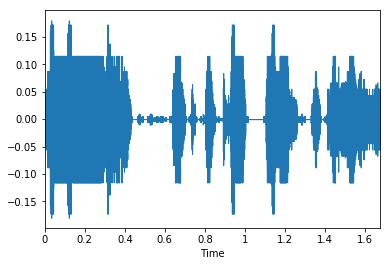

In [21]:
plt.figure()
librosa.display.waveplot(out[0].numpy())

In [22]:
out.shape

torch.Size([1, 36929])

In [23]:
out_path = os.path.expanduser(args.eval_out_path)
out_filename = '{}_{}_{}.wav'.format(os.path.basename(args.eval_audio_path).split('.')[0], args.eval_speaker_id, epoch)
out_file_path = os.path.join(out_path, out_filename)

# Save as audio
torchaudio.save(filepath=out_file_path, src=out, sample_rate=sr)